In [1]:
# default paramaters

max_epochs = 5
batch_size = 25

This notebook shows how to create a trianing template that can be invoqued from the [EOTDL](https://www.eotdl.com/) UI to train a model / perform hyperparameter search.

First, install the PytorchEO package if it is not already installed.

In [2]:
#!pip install pytorch-eo

Stage the dataset

In [3]:
from eotdl.datasets import stage_dataset

path = stage_dataset("EuroSAT-RGB", version=1, path="data", force=True, assets=True)
path

Staging assets: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


'data/EuroSAT-RGB'

Unzip assets if not already done

In [4]:
import os

# Path to the folder expected after unzip
unzipped_folder = os.path.join("data/train", "EuroSAT-RGB")
if not os.path.exists(unzipped_folder):
    !unzip -q {path}/EuroSAT-RGB.zip -d data/train

PytorchEO wrapper

In [5]:
from pytorch_eo.datasets import EuroSATRGB
import albumentations as A
import numpy as np
from einops import rearrange
from albumentations.pytorch import ToTensorV2

def clip(x, **kwargs): return np.clip(x, 0., 1.)
def add_channel(x, **kwargs): return rearrange(x, 'h w -> h w 1') if x.ndim == 2 else x

trans = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Normalize(0, 1, max_pixel_value=255),     # divide by 255
    A.Lambda(image=clip),                       # clip to [0,1]
    A.Lambda(image=add_channel),                # add channel dimension if only one band
    ToTensorV2()                                # convert to float tensor and channel first
])

ds = EuroSATRGB(train_trans=trans, path="data", download=False, data_folder='train/EuroSAT-RGB', batch_size=25) # batch size is set to 25 for visualization purposes, for training we use parameter in next cells
ds.setup()

In [6]:
ds.df

,image,label
0,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
1,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
2,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
3,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_2...,0
4,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
...,...,...
26995,data/train/EuroSAT-RGB/SeaLake/SeaLake_612.jpg,9
26996,data/train/EuroSAT-RGB/SeaLake/SeaLake_2863.jpg,9
26997,data/train/EuroSAT-RGB/SeaLake/SeaLake_606.jpg,9
26998,data/train/EuroSAT-RGB/SeaLake/SeaLake_2877.jpg,9


In [7]:
ds.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

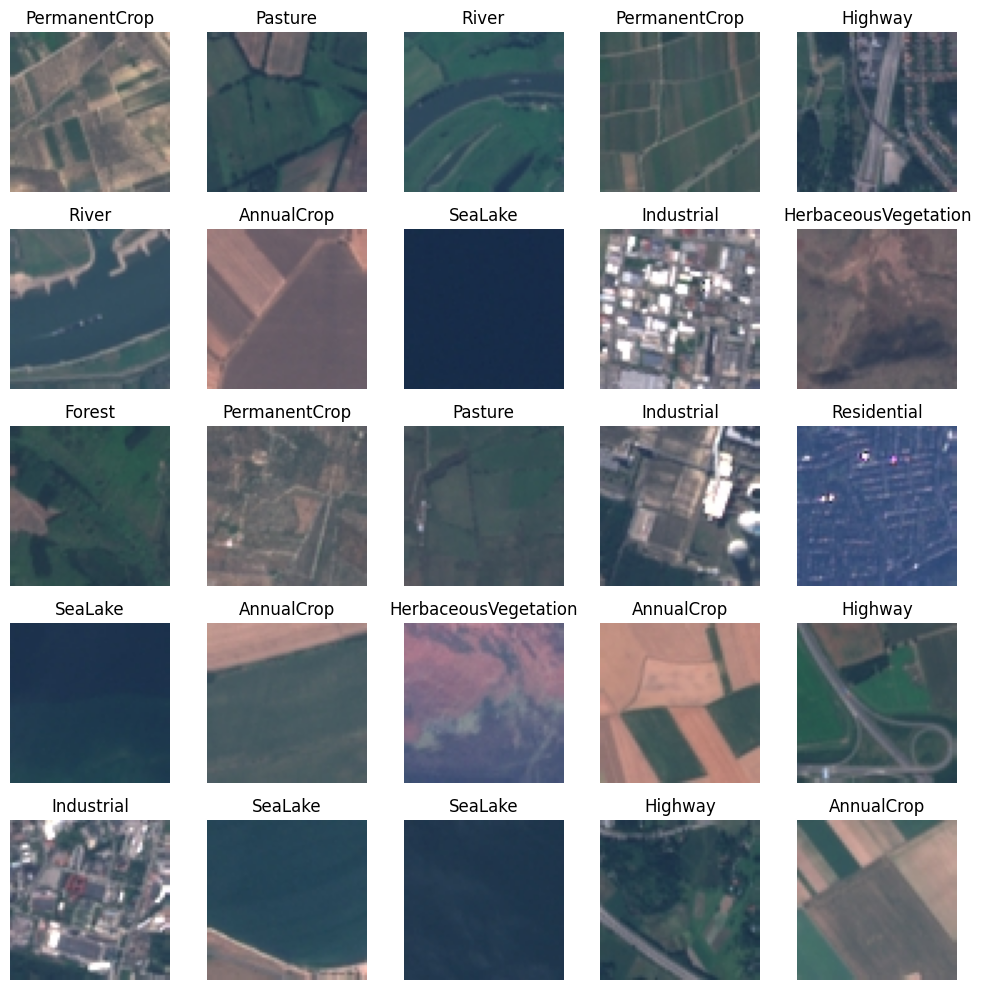

In [8]:
import matplotlib.pyplot as plt

# extract a batch of samples (you can also access val_dataloader or test_dataloader for the other splits)

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img.permute(1,2,0))
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Now we can train a model.

In [9]:
import torch 
from pytorch_eo.tasks.classification import ImageClassification
import lightning as L

ds = EuroSATRGB(train_trans=trans, path="data", download=False, data_folder='train/EuroSAT-RGB', batch_size=batch_size) 
task = ImageClassification(num_classes=ds.num_classes)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

trainer = L.Trainer(
    accelerator=device,
    devices=1,
    max_epochs=max_epochs,
)

trainer.fit(task, ds)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | ResNet        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

Once the model is trained, we can export the model to ONNX format and ingest to EOTDL following instructions [here](https://github.com/earthpulse/eotdl/blob/main/tutorials/notebooks/02_training.ipynb).